In [1]:
#Dataset preprocessing
import pandas as pd
import numpy as np

iowa = pd.read_csv("../Data/Iowa.csv")
ntl = pd.read_csv("../Data/ntl439_1_v1.csv")

iowa_processed = iowa.copy()
ntl_processed = ntl.copy()

ntl_processed['sampledate'] = pd.to_datetime(ntl_processed['sampledate'])
ntl_processed['Year'] = ntl_processed['sampledate'].dt.year
ntl_processed['DOY'] = ntl_processed['sampledate'].dt.dayofyear

ntl_processed['Lake'] = 'Lake Mendota'

ntl_processed = ntl_processed.rename(columns={
    'wtemp': 'Temperature',
    'do_sat': 'DissolvedOxygen_Saturation',
    'chlor_rfu': 'Chlorophyll',
    'phyco_rfu': 'Phycocyanin',
    'ph': 'pH'
})

In [2]:
#Combining Datasets

common_columns = ['Lake', 'Year', 'DOY', 'Chlorophyll', 'Phycocyanin', 
                  'DissolvedOxygen_Saturation', 'pH', 'Temperature']

iowa_final = iowa_processed[common_columns]
ntl_final = ntl_processed[common_columns]

combined_data = pd.concat([iowa_final, ntl_final], axis=0, ignore_index=True)

print("Combined Dataset Shape:", combined_data.shape)
print("\nCombined Dataset Info:")
print(combined_data.info())
print("\nFirst few rows:")
print(combined_data.head())
print("\nLast few rows:")
print(combined_data.tail())
print("\nLake value counts:")
print(combined_data['Lake'].value_counts())
print("\nMissing values:")
print(combined_data.isnull().sum())

combined_data.to_csv("../Data/combined_dataset.csv", index=False)

Combined Dataset Shape: (1061, 8)

Combined Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061 entries, 0 to 1060
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Lake                        1061 non-null   object 
 1   Year                        1061 non-null   int64  
 2   DOY                         1061 non-null   int64  
 3   Chlorophyll                 1061 non-null   float64
 4   Phycocyanin                 1061 non-null   float64
 5   DissolvedOxygen_Saturation  1061 non-null   float64
 6   pH                          1061 non-null   float64
 7   Temperature                 1061 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 66.4+ KB
None

First few rows:
             Lake  Year  DOY  Chlorophyll  Phycocyanin  \
0  Blackhawk Lake  2015  128         2.32         0.40   
1  Blackhawk Lake  2015  129         0.78         0.30   
2  Blac

In [5]:
#Identifying Invalid Data

df = pd.read_csv("../Data/combined_dataset.csv")

print(f"Dataset size: {len(df)} rows")
print("\nChecking for physically impossible values...")

impossible_ph = df[(df['pH'] < 0) | (df['pH'] > 14)]
print(f"\npH outside [0, 14]: {len(impossible_ph)} rows")
if len(impossible_ph) > 0:
    print(impossible_ph[['Lake', 'Year', 'DOY', 'pH']].head(10))

impossible_temp = df[df['Temperature'] < 0]
print(f"\nTemperature < 0°C: {len(impossible_temp)} rows")
if len(impossible_temp) > 0:
    print(impossible_temp[['Lake', 'Year', 'DOY', 'Temperature']].head(10))

impossible_do = df[(df['DissolvedOxygen_Saturation'] < 0) | (df['DissolvedOxygen_Saturation'] > 300)]
print(f"\nDissolved Oxygen outside [0, 300]%: {len(impossible_do)} rows")
if len(impossible_do) > 0:
    print(impossible_do[['Lake', 'Year', 'DOY', 'DissolvedOxygen_Saturation']].head(10))

impossible_chlor = df[df['Chlorophyll'] < 0]
print(f"\nChlorophyll < 0: {len(impossible_chlor)} rows")
if len(impossible_chlor) > 0:
    print(impossible_chlor[['Lake', 'Year', 'DOY', 'Chlorophyll']].head(10))

impossible_phyco = df[df['Phycocyanin'] < 0]
print(f"\nPhycocyanin < 0: {len(impossible_phyco)} rows")
if len(impossible_phyco) > 0:
    print(impossible_phyco[['Lake', 'Year', 'DOY', 'Phycocyanin']].head(10))

total_impossible = len(set(
    list(impossible_ph.index) + 
    list(impossible_temp.index) + 
    list(impossible_do.index) + 
    list(impossible_chlor.index) + 
    list(impossible_phyco.index)
))

print(f"\nTotal unique rows with impossible values: {total_impossible} ({total_impossible/len(df)*100:.2f}%)")

Dataset size: 1061 rows

Checking for physically impossible values...

pH outside [0, 14]: 0 rows

Temperature < 0°C: 0 rows

Dissolved Oxygen outside [0, 300]%: 1 rows
                  Lake  Year  DOY  DissolvedOxygen_Saturation
330  Green Valley Lake  2015  195                      314.77

Chlorophyll < 0: 0 rows

Phycocyanin < 0: 37 rows
             Lake  Year  DOY  Phycocyanin
664  Lake Mendota  2023  138        -0.03
665  Lake Mendota  2023  139        -0.04
829  Lake Mendota  2023  308        -0.02
830  Lake Mendota  2023  309        -0.03
831  Lake Mendota  2023  310        -0.04
832  Lake Mendota  2023  311        -0.06
833  Lake Mendota  2023  312        -0.05
835  Lake Mendota  2023  314        -0.01
842  Lake Mendota  2024   86        -0.08
843  Lake Mendota  2024   87        -0.08

Total unique rows with impossible values: 38 (3.58%)


In [8]:
# Removing rows with impossible values

print(f"\nOriginal dataset size: {len(df)} rows")

df_clean = df[
    (df['pH'] >= 0) & (df['pH'] <= 14) &
    (df['Temperature'] >= 0) &
    (df['DissolvedOxygen_Saturation'] >= 0) & (df['DissolvedOxygen_Saturation'] <= 300) &
    (df['Chlorophyll'] >= 0) &
    (df['Phycocyanin'] >= 0)
].copy()

print(f"Cleaned dataset size: {len(df_clean)} rows")
print(f"Removed: {len(df) - len(df_clean)} rows ({(len(df) - len(df_clean))/len(df)*100:.2f}%)")

df_clean.to_csv("../Data/combined_dataset_no_invalid.csv", index=False)
print("\nCleaned dataset saved to: ../Data/combined_dataset_no_invalid.csv")


Original dataset size: 1061 rows
Cleaned dataset size: 1023 rows
Removed: 38 rows (3.58%)

Cleaned dataset saved to: ../Data/combined_dataset_no_invalid.csv


DOY: 0 outliers (0.00%)
Chlorophyll: 22 outliers (2.15%)
Phycocyanin: 23 outliers (2.25%)
DissolvedOxygen_Saturation: 9 outliers (0.88%)
pH: 5 outliers (0.49%)
Temperature: 17 outliers (1.66%)


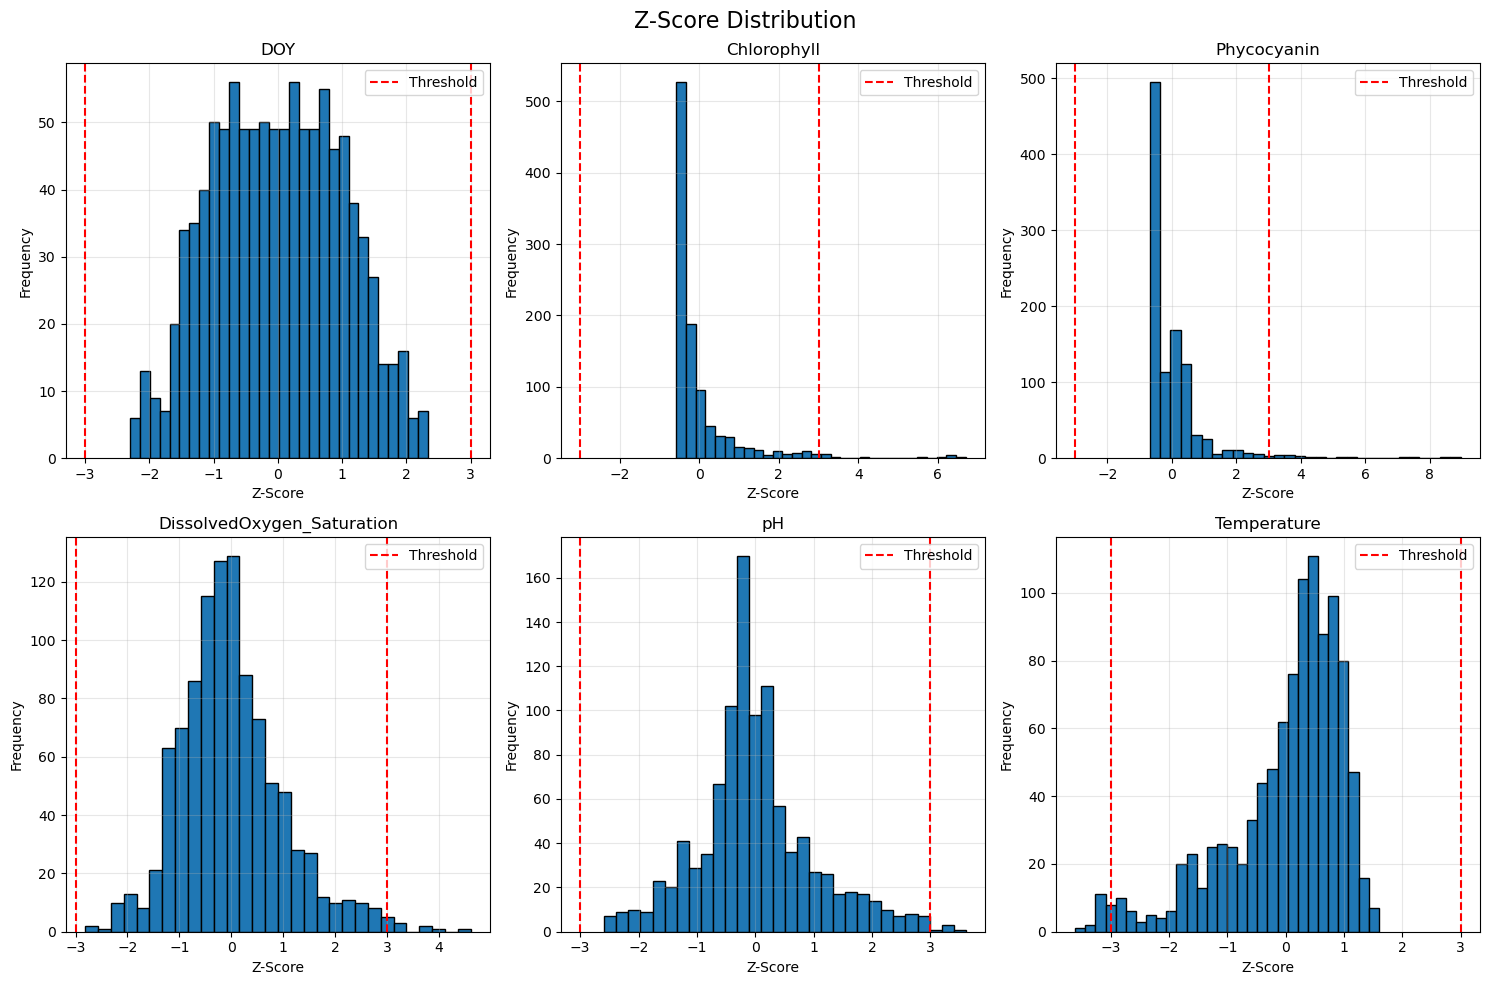

In [9]:
# Z-Score outlier identification (after impossible data cleaned)

import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("../Data/combined_dataset_no_invalid.csv")
numeric_cols = ['DOY', 'Chlorophyll', 'Phycocyanin', 'DissolvedOxygen_Saturation', 'pH', 'Temperature']

for col in numeric_cols:
    z_scores = np.abs(stats.zscore(df[col]))
    outliers = df[z_scores > 3]
    
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.2f}%)")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Z-Score Distribution', fontsize=16)

for idx, col in enumerate(numeric_cols):
    row = idx // 3
    col_idx = idx % 3
    z_scores = stats.zscore(df[col])
    axes[row, col_idx].hist(z_scores, bins=30, edgecolor='black')
    axes[row, col_idx].axvline(-3, color='r', linestyle='--', label='Threshold')
    axes[row, col_idx].axvline(3, color='r', linestyle='--')
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].set_xlabel('Z-Score')
    axes[row, col_idx].set_ylabel('Frequency')
    axes[row, col_idx].legend()
    axes[row, col_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
#Final dataset
print(f"\nOriginal dataset size: {len(df)} rows")

outlier_indices = set()

for col in numeric_cols:
    z_scores = np.abs(stats.zscore(df[col]))
    col_outliers = df[z_scores > 3].index
    outlier_indices.update(col_outliers)
    print(f"{col}: {len(col_outliers)} outliers")

print(f"\nTotal unique rows with outliers: {len(outlier_indices)}")

df_no_outliers = df.drop(outlier_indices).reset_index(drop=True)

print(f"Dataset size after removal: {len(df_no_outliers)} rows")
print(f"Removed: {len(df) - len(df_no_outliers)} rows ({(len(df) - len(df_no_outliers))/len(df)*100:.2f}%)")

df_no_outliers.to_csv("../Data/final_dataset.csv", index=False)
print("\nDataset saved to: ../Data/final_dataset.csv")


Original dataset size: 1023 rows
DOY: 0 outliers
Chlorophyll: 22 outliers
Phycocyanin: 23 outliers
DissolvedOxygen_Saturation: 9 outliers
pH: 5 outliers
Temperature: 17 outliers

Total unique rows with outliers: 67
Dataset size after removal: 956 rows
Removed: 67 rows (6.55%)

Dataset saved to: ../Data/final_dataset.csv
